#Allowing Import from Parent Directory

In [2]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#Importing Packages

In [4]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da
import tools.visualisation as visual

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Loading and Reshaping Data

In [ ]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [ ]:
# We sliced our data to even numbers to make it
# convenient for max-pooling when we train our model

In [6]:
train_full = loaddata.load_data(path_train)[:,:858,:910]
test = loaddata.load_data(path_test)[:,:858,:910]
model_data = loaddata.load_data(path_back)[:,:858,:910]
satellite_data = loaddata.load_data(path_obs)[:,:858,:910]

In [72]:
# Due to RAM and time limitations when running the convolutional autoencoder, we had to reduce the dataset massively. 

In [7]:
train = train_full[0:100]

In [8]:
print(f"Train data shape reshaping: {np.shape(train)}")
print(f"Test data shape reshaping: {np.shape(test)}")
print(f"Background data shape reshaping: {np.shape(model_data)}")
print(f"Observational data shape reshaping: {np.shape(satellite_data)}")

Train data shape reshaping: (100, 858, 910)
Test data shape reshaping: (300, 858, 910)
Background data shape reshaping: (5, 858, 910)
Observational data shape reshaping: (5, 858, 910)


# Convolutional Autoencoder

In order to improve the robustness of the small perturbations around the data points of the training set, the contraction autoencoder adds a regular term to the basic autoencoder in the form of the norm of the encoder's mapping on the input matrix (the specific form is as follows), in order to force it to learn the mapping with stronger contraction on the training sample.  

Normally, the CAE autoencoder will consist of dense layers since the contraction penalty wants to keep the learned feature constant in all directions (it shrinks in all directions), while the reconstruction error wants to reconstruct the learned feature back into the input. To extract our characteristics efficiently, avoid parameter redundancy at dense layer and avoid over-fitting, we designed a full convolutional layer and pooling layer to construct our model.

However, in the practical running, there are still some over-fitting problems,so maybe we could optimize our model with extra dropout layers and adjust our lose function to get lower mse given more time. 

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Conv2D(16,(9,9),padding='same',activation='relu'),
                                       keras.layers.MaxPooling2D((13,13)),
                                       keras.layers.Conv2D(1,(7,7),padding='same',activation='relu'),
                                       keras.layers.MaxPooling2D((11, 7)),
                                       keras.layers.Flatten(),
                                       ])
decoder = keras.models.Sequential([
                                    keras.layers.Reshape((6,10,1)),
                                    keras.layers.Conv2D(1, (5, 5), padding='same', activation='relu'),
                                    keras.layers.UpSampling2D((11, 7)),
                                    keras.layers.Conv2D(16, (7, 7), padding='same', activation='relu'),
                                    keras.layers.UpSampling2D((13, 13)),
                                    keras.layers.Conv2D(1, (9, 9), padding='same', activation='sigmoid'),
                                    ])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['mse'])
print('Encoder:')
encoder.build(input_shape=(None,858,910,1))
encoder.summary()
print('\nDencoder:')
decoder.build(input_shape=(None,60,1))
decoder.summary()
print('\nAutoencoder:')
autoencoder.build(input_shape=(None,858,910,1))
autoencoder.summary()

Encoder:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 858, 910, 16)      1312      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 70, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 66, 70, 1)         785       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 10, 1)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
Total params: 2,097
Trainable params: 2,097
Non

In [10]:
# We use the following callback to prevent overfitting

earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
# Due to RAM limitations we were unable to run a bigger batch size. Also, due
# to time we could only run a small number of epochs. 

In [ ]:
start = time.time()
history = autoencoder.fit(train, 
                          train, 
                          epochs=8, 
                          batch_size=8, 
                          verbose=2, 
                          validation_data = (test, test), 
                          shuffle = True, callbacks = [earlystopping])
time_ae = time.time() - start
print('Execution time: ', time_ae)

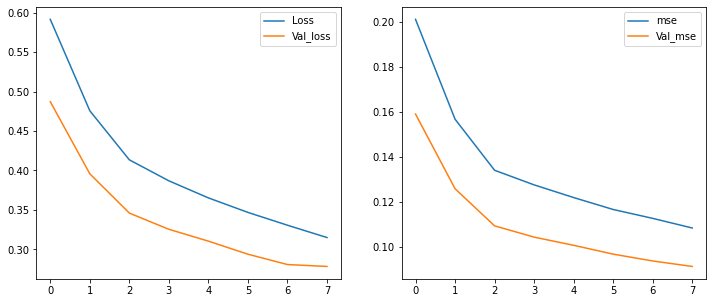

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].legend(['Loss', 'Val_loss'])
axes[1].plot(history.history['mse'])
axes[1].plot(history.history['val_mse'])
axes[1].legend(['mse', 'Val_mse'])

In [13]:
test_recovered = autoencoder.predict(test)
mse_test = da.mse(test.reshape((10,-1)), test_recovered.reshape((10,-1)))
print('mse: ', mse_test)

mse:  0.09133880579540682


#Data Assimilation - Kalman Filter (BLUE)

In [68]:
# Through experimenting with different computations of R, we found the following to give us the
# lowest MSE after data assimilation. 

In [65]:
## Setting the required variables for data assimilation

model_data_compr = encoder.predict(model_data) # Compressing the model Data
satellite_data_compr = encoder.predict(satellite_data) # Compressing the satellite Data

latent_space = satellite_data_compr.shape[1]
nNodes = latent_space  #latent_space is the size of the compressed variables or number of principal components used
I = np.identity(nNodes)
R = da.covariance_diagonal_only(satellite_data_compr.T, latent_space) * 500
H = I 
B = I*0.000001

In [66]:
## Performing data assimilation
updated_data_array = da.assimilate(B, H, R, model_data_compr, satellite_data_compr)

In [67]:
## Printing MSE in latent space
mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
print('MSE before assimilation in latent space: ', mse_before_DA )
print('MSE after assimilation in latent space: ', mse_after_DA)

## Printing MSE in Physical space space
updated_data_recon = decoder.predict(updated_data_array)
mse_before_DA_physical = da.mse(satellite_data, model_data)
mse_after_DA_physical = da.mse(satellite_data, updated_data_recon.squeeze())

print('MSE before assimilation in physical space: ', mse_before_DA_physical)
print('MSE after assimilation in physical space: ', mse_after_DA_physical)

MSE before assimilation in latent space:  0.3622854
MSE after assimilation in latent space:  0.25463773148562235
MSE before assimilation in physical space:  0.12137401060477984
MSE after assimilation in physical space:  0.10920173230580799
